# 4 - Data Understanding & Annotation

At this point, we should have opened and looked at a number of PDFs and started to get a sense of the corpus content, variation, and unique aspects.

Now, it's time to start assessing the corpus based on our business goals - identifying liability caps and payment terms.

In [2]:
import pandas as pd
import glob
import spacy
import os
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sentence_transformers import SentenceTransformer
import annoy
from annoy import AnnoyIndex
import umap.umap_ as umap
from sklearn.metrics.pairwise import cosine_similarity
import random
import altair as alt
import re
from collections import Counter
import string
import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
from dotenv import load_dotenv

### if you do not already have the nltk packages below, uncomment and run once to download (then re-comment)
nltk.download('stopwords')
# nltk.download('punkt')

In [3]:
load_dotenv()
HOME_DIRECTORY = os.getenv("HOME_DIRECTORY")

<br/>

First, let's load a sentence embedding model and apply across the corpus. We'll save the results so that we only have to do this heavier compute task once.

In [4]:
sent_emb_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [5]:
# Read the DataFrame from the Pickle file
sentence_texts = pd.read_pickle(os.path.join(HOME_DIRECTORY, 'data', 'data_pickles', 'corpus_sentences.pkl'))

# Display the loaded DataFrame
sentence_texts.head()

,filename,sentence_index,sentence_text
0,Kindlyex10-1.htm,0,EX-10.1 2 ex10-1.htm Exhibit\n10.1 CERTAIN\nSC...
1,Kindlyex10-1.htm,1,THE COMPANY\nAGREES TO FILE SUPPLEMENTALLY TO ...
2,Kindlyex10-1.htm,2,OMITTED SCHEDULES AND INFORMATION ARE REPRESEN...
3,Kindlyex10-1.htm,3,"Kindly\nMD, INC."
4,Kindlyex10-1.htm,4,BOARD\nOF DIRECTORS - RETAINER AGREEMENT This\...


<br/>

Run the below cell only once to create and save the embeddings to a pickle, as this is a time consuming process. Once the pickle is saved, comment these lines out and load from the pickle to save time:

In [6]:
# sentence_texts['Embedding'] = sentence_texts['sentence_text'].apply(lambda x: sent_emb_model.encode(x))
# sentence_texts.to_pickle(os.path.join(HOME_DIRECTORY, 'data', 'data_pickles', 'corpus_sentences_embedded.pkl'))

After creating the file, load from pickle:

In [7]:
# Read the DataFrame from the Pickle file
sentence_embeddings = pd.read_pickle(os.path.join(HOME_DIRECTORY, 'data', 'data_pickles', 'corpus_sentences_embedded.pkl'))

# Display the loaded DataFrame
sentence_embeddings.head()

,filename,sentence_index,sentence_text,Embedding
0,00002MGK.pdf.txt,0,Modification Summary Report\n\n,"[-0.41111374, 0.21261811, 0.20041092, -0.20724..."
1,00002MGK.pdf.txt,1,Conteact (PO) Number: 1406\nModification Revis...,"[-0.5395347, 0.098074794, 0.105878145, -0.1364..."
2,00002MGK.pdf.txt,2,Specification Number: 3858\n\n,"[-1.0228841, 0.4157112, -0.75348186, -0.048902..."
3,00002MGK.pdf.txt,3,Name of Contractor: GLOBETROTTERS ENGINEERING ...,"[-0.38846922, -0.24451904, -0.4939656, -0.3636..."
4,00002MGK.pdf.txt,4,City Department: DEPARTMENT OF CONSTRUCTION AN...,"[0.008176829, -0.01078279, -0.06635815, -0.172..."


<br/><br/>

## Set up a semantic search with Annoy

We leverage the Annoy ("Approximate Nearest Neighbors, Oh Yeah") package to set up a search index across all of our sentences in our corpus. This will allow us to use a new "entry" to search, identify, and return similar results back.

https://github.com/spotify/annoy

In [8]:
vec_len = len(sentence_embeddings['Embedding'].values[0])  # Length of item vector that will be indexed

<br/>

As this is also a time consuming process, run the below cell only once to create the Annoy index and save. Once the annoy index is saved, comment these lines out and load to save time.

*Note*: The annoy file is also available via the Google drive.

In [10]:
## Run once and save - once run, re-comment the below

# ann_ind = AnnoyIndex(vec_len, 'angular')
# for i, embed in enumerate(sentence_embeddings['Embedding'].values):
#     ann_ind.add_item(i, embed)

# ann_ind.set_seed(1)
# ann_ind.build(15)
# ann_ind.save(os.path.join(HOME_DIRECTORY, 'data', 'annoy_indices', 'corpus_annoy_db.ann'));

<br/>

After creating the search index, let's load from file to avoid re-creating each time.

Now that we've created an vectorized database, we can search by an existing index, as below:

In [11]:
u = AnnoyIndex(vec_len, 'angular')
u.load(os.path.join(HOME_DIRECTORY, 'data', 'annoy_indices', 'corpus_annoy_db.ann')) ## load our saved annoy index

print(u.get_nns_by_item(250, 100)) # find the 100 nearest neighbors' indices

[250, 463263, 704528, 770307, 501826, 574813, 399626, 85908, 104516, 133404, 145924, 201840, 212737, 237989, 345417, 349724, 386969, 750203, 65625, 53080, 565212, 512571, 91318, 155956, 283504, 198161, 672455, 204618, 711825, 78427, 48808, 184705, 266817, 688847, 254515, 69197, 109391, 102514, 442002, 20180, 98224, 158127, 380040, 420099, 493791, 561663, 569628, 242612, 73702, 747808, 542439, 138754, 430293, 278609, 638199, 751923, 324449, 480513, 122502, 519132, 278656, 78490, 420162, 283567, 387021, 266869, 553986, 133444, 688926, 542498, 20255, 254584, 387065, 480598, 561738, 569702, 574887, 604147, 688975, 604111, 696696, 20229, 104566, 565262, 561715, 201890, 442053, 109430, 380083, 638249, 198206, 324492, 770358, 711874, 512624, 349769, 238044, 102565, 750267, 751996]


<br/>

Check and confirm the total number of items in our search index:

In [12]:
u.get_n_items()

967949

<br/>

And examine the results for a few specific indices...

In [13]:
sentence_embeddings['sentence_text'].iloc[250]

'Consultant resin responsible forthe professional and echnical accuracy of\nAll Services or Deliverables furnished, whether by Consultant ors Subcontractor or ther on its behalf.'

In [14]:
sentence_embeddings['sentence_text'].iloc[463263]

'Consultant remains\nresponsible forthe professional and technical accuracy of all Services or\nDeliverables furnished, whether by Consultant or its Subcontractors or others on\ntts behalf.'

<br/> to confirm it's working reasonably well...

<br/>

Now, we can also search based on new text - let's try a quick example:

In [15]:
emd_new = sent_emb_model.encode('The liability shall not exceed the total fees paid')
print(u.get_nns_by_vector(emd_new, 100)) # will find the 100 nearest neighbors' indices

[774796, 852467, 814282, 927600, 787727, 899568, 829720, 784164, 784004, 947300, 814283, 828595, 901023, 788932, 905379, 947282, 793831, 901041, 911382, 863504, 801420, 849526, 871834, 917740, 947294, 942482, 943701, 917769, 842173, 960084, 913358, 942923, 949208, 924469, 841958, 928101, 889849, 823177, 889860, 944286, 960126, 802593, 882188, 966591, 784167, 807076, 129178, 959954, 177826, 938482, 784448, 933136, 917775, 584854, 696360, 829719, 859102, 786493, 927271, 872146, 859105, 806870, 846966, 964729, 813486, 247689, 910020, 945085, 948643, 239586, 927719, 883033, 926276, 726867, 775025, 819579, 888038, 753471, 868603, 819844, 888303, 341434, 585709, 895272, 941556, 754128, 585443, 951624, 824442, 898765, 829730, 750251, 920465, 782413, 960086, 845427, 451224, 941557, 225480, 814494]


In [16]:
sentence_embeddings['sentence_text'].iloc[774796]

'In the event this limitation of damages is held unenforceable, the parties agree that because of the difficulty in foreseeing possible damages, Consultant’s liability to the Company shall not exceed the amount of any payments made by the Company to Consultant under this Agreement, any such liability for payment to be construed as liquidated damages and not as a penalty.'

In [17]:
sentence_embeddings['sentence_text'].iloc[787727]

'THE AGGREGATE LIABILITY FOR DAMAGES, OF WHATEVER NATURE, UNDER THIS AGREEMENT (WHETHER DIRECT OR INDIRECT, OR UNDER CONTRACT, TORT, STATUTE, REGULATION, OR ANY OTHER THEORY OF LAW OR EQUITY) WILL NOT EXCEED, UNDER ANY CIRCUMSTANCES THE MANAGEMENT FEE PAID UNDER THIS AGREEMENT.'

Confirm that the examples returned are also similar to our search terms.

<br/>

### Exercise 4.1:

Test out a new search based on an example clause title or sentence of your choosing.
- Examine the first couple indices and confirm if the level of similarity is consistent.
- Examine the 99th and 100th indices. Are these still reasonably similar?

<br/>

<br/>

### Exercise 4.2:

What if our search text is significantly longer? Test another search with an entire clause made up of multiple sentences, as opposed to a single sentence or phrase.
- Examine the first couple indices and confirm if the level of similarity is consistent.
- Examine the 99th and 100th indices. Are these still reasonably similar?


<br/>

<br/>

### Exercise 4.3:

Why might a longer text (many sentences or a paragraph) lead to poor similarity search results?

<br/>

<br/><br/><br/>

## Visualize and Explore Dynamically

On the cloud, we encourage users to map the entire corpus, but for laptops running this code, we suggest limiting the data to 5,000 or so.

In [18]:
def plot_nn_interactive(sentence_embeddings: pd.DataFrame, embedding_col: str, sent_col: str, sample_size: int = None):
    """
    Generates an interactive scatter plot of sentence embeddings reduced to 2D using UMAP.
    The plot allows users to hover over points to see the corresponding sentence text.

    Args:
        sentence_embeddings (pd.DataFrame): A Pandas DataFrame containing sentence data.
                                            Must include columns for embeddings and sentence text.
        embedding_col (str): The name of the column in `sentence_embeddings` that contains
                             the high-dimensional sentence embedding vectors.
        sent_col (str): The name of the column in `sentence_embeddings` that contains
                        the actual sentence text. This text will be shown in tooltips.
        sample_size (int, optional): The number of data points to randomly sample from
                                     `sentence_embeddings` before performing UMAP reduction
                                     and plotting. If None, all data points are used.
                                     Defaults to None.

    Returns:
        altair.Chart: An Altair interactive scatter plot object.
    """
    # Determine whether to sample the data or use all of it.
    if sample_size is None:
        # If no sample size is specified, use the entire DataFrame.
        sentence_embeddings_sample = sentence_embeddings
    else:
        # If a sample size is specified, randomly sample 'sample_size' rows from the DataFrame.
        # random_state ensures reproducibility of the sampling.
        sentence_embeddings_sample = sentence_embeddings.sample(sample_size, random_state=10935)

    # Initialize UMAP (Uniform Manifold Approximation and Projection) reducer.
    # UMAP is a dimensionality reduction technique often used for visualization of high-dimensional data.
    # n_neighbors: Controls how UMAP balances local versus global structure in the data.
    reducer = umap.UMAP(n_neighbors=20)
    # Apply UMAP to reduce the dimensionality of the embeddings to 2D.
    # First, convert the list of embedding arrays in the specified column into a NumPy array of NumPy arrays.
    # Then, apply the UMAP transformation.
    umap_embeds = reducer.fit_transform(np.array([np.array(x) for x in sentence_embeddings_sample[embedding_col].values]))
    
    # Create a new Pandas DataFrame for plotting with Altair.
    # This DataFrame will contain the original sentence text and the new 2D UMAP coordinates.
    df_explore = pd.DataFrame(
        data = {
            'text': sentence_embeddings_sample[sent_col].values # Text to show for hover tooltip
        }
    )
    
    # Add the UMAP reduced coordinates (x and y) as new columns to the plotting DataFrame.
    df_explore['x'] = umap_embeds[:,0]
    df_explore['y'] = umap_embeds[:,1]
    
    # Create an Altair scatter plot.
    # scale=alt.Scale(zero=False) ensures the axis doesn't necessarily start at zero,
    # which can be useful for better visualization of data distribution.
    chart = alt.Chart(df_explore).mark_circle(size=60).encode(
        x = alt.X(
            'x',
            scale=alt.Scale(zero=False)
        ),
        y = alt.Y(
            'y',
            scale=alt.Scale(zero=False)
        ),
        tooltip=['text'], # Add tooltip text set up previously
    ).properties(
        title='Visualization of Corpus Embeddings',
        width=700,
        height=400)
    
    return chart.interactive()

plot_nn_interactive(sentence_embeddings, 'Embedding', 'sentence_text', sample_size=5000)

alt.Chart(...)

<br/>

### Exercise 4.4:

Zoom very close in on a particular cluster of points in the above interactive chart. Do you agree that this small set of co-located points are similar in content and meaning? 

Examine 3 clusters and comment on:
1. Do the sentences in the cluster seem similar?
2. Is so, what is the "topic" of the cluster?
3. What are common attributes of the cluster?

<br/>

<br/><br/>

### Understanding Embedding Space

Let's dive a tad deeper into understanding embeddings - the benefits and the limitations of using embeddings and how they are impacted by different NLP aspects and tasks.

<br/>

#### Scenario 1: The Impact of Data Quality

Let's first take a look at how two embeddings - the same sentences, but in the first case with higher data quality (better OCR results) compared to a second case or lower data quality (poor OCR results):

In [19]:
def dot(A,B): 
    return (sum(a*b for a,b in zip(A,B)))
    
def calc_cosine_similarity(a,b):
    a = a
    b = b
    return dot(a,b) / ( (dot(a,a) **.5) * (dot(b,b) ** .5) )

In [20]:
good_ocr = sent_emb_model.encode('Payment Term -Net iteen days from the dat ofinvoic')
bad_ocr = sent_emb_model.encode('Payment Terms - net fifteen days from the date of invoice')

calc_cosine_similarity(good_ocr, bad_ocr)

np.float32(0.8128127)

As we can see - the two embeddings for the same sentence from higher and lower quality data are still highly similar.

<br/>

Let's take another case with a longer sentence with more OCR errors:

In [21]:
good_ocr = sent_emb_model.encode('''Except as provided under Section 2.12 (b)below, Contractor's liability for\nany and all claims brought 
                    against it by the City, individually or in the\naggregate arising out of or relating to this Agreement, whether 
                    sounding\nin contract, warranty, tort, strict liability or any other cause of action, is\nlimited to $2.0 million or 
                    the aggregate amount of fees paid or to be paid\nunder this Agreement, whichever amount is greater.''')

bad_ocr = sent_emb_model.encode('''Exceptas provided under Section 2. |2 Cb bel0w, Contractor s 1iability for\nany and a11 claimS brought 
                    against it by the City.. individuaiiy or in the\naggregate arising out of or relatlng t0 this Agreement, whether 
                    soundingin contract warranty, tort, strict 1iabiiity or any other cause of action, is 1lmited to $2.0 mi1|ion or 
                    the aggregate amount of fees paid or tobe paid\nunder this Agreement, whichever amount is greater.''')

calc_cosine_similarity(good_ocr, bad_ocr)

np.float32(0.70750606)

<br/>
<br/>

#### Scenario 2: The Impact of NLP Preprocessing

Embeddings may also be affected by the preprocessing choices we take. Let's look at how embeddings can change - minimally - with preprocessing applied. Below, we'll compare the "before" and "after":

In [22]:
def preprocess_sentence(sentence):
    # Tokenization
    tokens = nltk.word_tokenize(sentence)
    
    # Lowercasing
    tokens = [token.lower() for token in tokens]
    
    # Remove punctuation
    table = str.maketrans('', '', string.punctuation)
    tokens = [token.translate(table) for token in tokens]
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Remove empty tokens
    tokens = [token for token in tokens if token.strip()]
    
    return tokens

In [23]:
raw_text = '''Except as provided under Section 2.12 (b)below, Contractor's liability for\nany and all claims brought 
                    against it by the City, individually or in the\naggregate arising out of or relating to this Agreement, whether 
                    sounding\nin contract, warranty, tort, strict liability or any other cause of action, is\nlimited to $2.0 million or 
                    the aggregate amount of fees paid or tobe paid\nunder this Agreement, whichever amount is greater.'''
preprocessed_text = ' '.join(preprocess_sentence(raw_text))
print('Preprocessed:',  preprocessed_text)

preprocessed = sent_emb_model.encode(preprocessed_text)
raw = sent_emb_model.encode(raw_text)

calc_cosine_similarity(raw, preprocessed)

Preprocessed: except provided section 212 b contractor liability claims brought city individually aggregate arising relating agreement whether sounding contract warranty tort strict liability cause action limited 20 million aggregate amount fees paid tobe paid agreement whichever amount greater


np.float32(0.8427316)

<br/>

Now, let's examine what this analysis looks like not for a single example, but look instead at the entire distribution across an example document, comparing raw OCR text to that same sentence, with standard NLP preprocessing techniques applied:

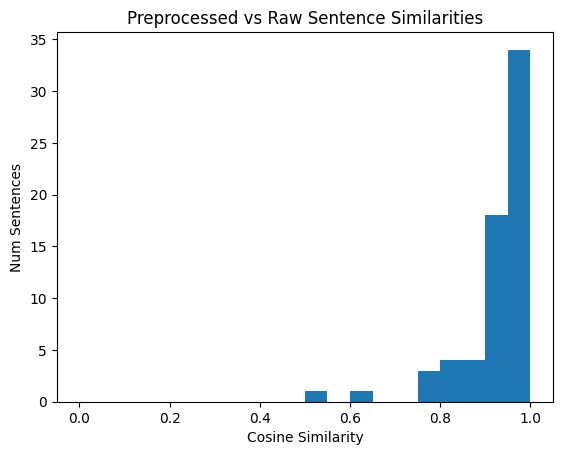

In [24]:
prep_comp_sims = []
for s in sentence_embeddings[sentence_embeddings['filename']=='00002MGK.pdf.txt']['sentence_text'].values:
    raw = sent_emb_model.encode(s)
    preprocessed = sent_emb_model.encode(' '.join(preprocess_sentence(s)))
    prep_comp_sims.append(calc_cosine_similarity(raw, preprocessed))


plt.hist(prep_comp_sims, bins=np.arange(0,1.01,0.05))
plt.title('Preprocessed vs Raw Sentence Similarities'); plt.xlabel('Cosine Similarity'); plt.ylabel('Num Sentences');

<br/><br/>

#### Scenario 3: When are embeddings useful features?

If we have two example that are similar language but a different answer, embeddings are no longer helpful to differentiate between classes or values. This is a further indication that while embeddings can be helpful in the retrieval step, they are less useful in differentiating across our annotation set:

In [25]:
net30 = sent_emb_model.encode('Payment for goods and services rendered shall be due within 30 days from the date of invoice ("Net 30").')
net60 = sent_emb_model.encode('Payment for goods and services rendered shall be due within 60 days from the date of the invoice.')

calc_cosine_similarity(net30, net60)

np.float32(0.8710548)

In [26]:
liability_2m = sent_emb_model.encode('''Except as provided under Section 2.12 (b)below, Contractor's liability for\nany and all claims brought 
                    against it by the City, individually or in the\naggregate arising out of or relating to this Agreement, whether 
                    sounding\nin contract, warranty, tort, strict liability or any other cause of action, is\nlimited to $2.0 million or 
                    the aggregate amount of fees paid or to be paid\nunder this Agreement, whichever amount is greater.''')

liability_1m = sent_emb_model.encode("""The total liability of Contractor's liability under this agreement shall not exceed the total
                                    amount paid by Cook County under this agreement or $1,000,000, whichever amount is greater.""")

calc_cosine_similarity(liability_2m, liability_1m)

np.float32(0.78835416)

<br/>

The above examples help demonstrate the concept that the embedding variation across sentences and documents is significantly broader than the embedding variation within our annotations. This indicates two things:
1. Embeddings are helpful in differentiating amongst topics in a document to find information that is helpful
2. Embeddings are not helpful in differentiating across topics within a specific set of annotations

This indicates that embeddings have strong discriminatory power in helping us retrieve relevant information from a document, but that power is lost if we are trying to classify our set of annotated sentences into more granular categories. In the latter case, we will want to choose a set of features that make more clear, discriminating boundaries between the classes we are interested in.

<br/><br/><br/>

## Identify Annotation Candidates - Semantic Search

Now, let's turn to identifying candidates for annotation, leveraging our semantic search setup.

First, let's create a few functions to help us:
1. Create a few "seed" examples for each of our two fields of interest
    1. Payment Terms
    2. Limitation of Liability
2. Execute a search based the "seeds" with our Annoy index 
3. Clean up that search to have a cohesive list of candidate annotations - remove adjacent results, add surrounding context, remove duplicates, etc.

In [27]:
def semantic_search_results(search_embeds: list, u=u, n: int = 1000) -> list:
    """
    Performs a semantic search using an Annoy index and processes the results.

    This function takes a list of search embeddings, queries an Annoy index (u)
    to find the nearest neighbors for each embedding, and then filters these
    results to remove adjacent indices, which are typically undesirable when
    extracting text with context windows.

    Args:
        search_embeds (list): A list of embedding vectors to use for the search.
        u (AnnoyIndex, optional): An Annoy index object to perform nearest neighbor searches.
                                  Defaults to a global 'u' object.
        n (int, optional): The number of nearest neighbors to retrieve for each search embedding.
                           Defaults to 1000.

    Returns:
        list: A filtered list of unique, non-adjacent indices representing the
              semantic search results.
    """
    search_results = []
    # Iterate through each search embedding provided
    for emd_new in search_embeds:
        # Use the Annoy index to find the 'n' nearest neighbors (indices) for the current embedding
        srch = u.get_nns_by_vector(emd_new, n)
        # Extend the overall list of search results with the new neighbors found
        search_results.extend(srch)
            
    # Convert the list to a set to remove duplicate indices, then sort them,
    # and convert back to a list. This ensures uniqueness and order.
    search_results = set(sorted(search_results))
    # Filter the list to remove indices that are directly adjacent (e.g., if index 5 and 6 are both present,
    # one might be removed based on the 'remove_plus_one' logic)
    filtered_list = remove_plus_one(list(search_results))
    return filtered_list

## We will use a context window when we extract text out for annotation, so we'll want to remove adjacent indices in our search results.
## For example, we don't want both sentence 1 and sentence 2 if we're going to buffer sentence 1 with sentence 2 in the output,
## as this would lead to redundant information. The logic checks for sequences of 3 or more consecutive indices.
def remove_plus_one(input_list: list) -> list:
    """
    Removes sequences of adjacent integers from a sorted list, specifically targeting
    sequences of 3 or more consecutive numbers by keeping only the first element
    of such a sequence. This is useful for preventing redundant context windows.

    Args:
        input_list (list): A sorted list of integers (indices).

    Returns:
        list: A new list with adjacent indices removed based on the defined logic.
    """
    result = []
    i = 0
    # Iterate through the input list
    while i < len(input_list):
        count = 1  # Initialize count for consecutive numbers
        j = i + 1  # Start checking from the next element
        # Check for consecutive numbers
        while j < len(input_list) and input_list[j] - input_list[j - 1] == 1:
            count += 1  # Increment count if consecutive
            j += 1      # Move to the next element
        
        # If 3 or more consecutive numbers are found, append only the first number of the sequence
        # and advance 'i' to skip the rest of the sequence minus one, effectively keeping only the first
        # and then moving to the next non-consecutive number.
        if count >= 3:
            result.append(input_list[i])
            i = j - 1 # Jump 'i' to the end of the consecutive sequence
        else:
            # If fewer than 3 consecutive numbers, append the current number
            result.append(input_list[i])
        i += 1 # Move to the next element
    return result

def sort_lists_together(list1: list, list2: list):
    """
    Sorts two lists based on the order of elements in the first list.

    Args:
        list1 (list): The primary list to sort by.
        list2 (list): The secondary list to be sorted in parallel with list1.

    Returns:
        tuple: A tuple containing two sorted lists (sorted_list1, sorted_list2).
    """
    # Combine the two lists into pairs of (element_from_list1, element_from_list2)
    combined_lists = zip(list1, list2) 
    # Sort the combined list of pairs based on the elements from list1 (x[0])
    sorted_combined_lists = sorted(combined_lists, key=lambda x: x[0]) 
    # Unzip the sorted pairs back into two separate lists
    sorted_list1, sorted_list2 = zip(*sorted_combined_lists) 
    return sorted_list1, sorted_list2

def apply_regex_filter(regex_filter: list or None, txt: str) -> bool:
    """
    Applies a list of regular expressions to a given text.

    The function returns True if `regex_filter` is None (no filter applied),
    or if any of the regular expressions in the `regex_filter` list match
    (case-insensitively) within the provided text.

    Args:
        regex_filter (list or None): A list of regular expression strings, or None if no filter is to be applied.
        txt (str): The text to apply the regular expressions against.

    Returns:
        bool: True if the text passes the filter, False otherwise.
    """
    # If no regex filter is provided, all text passes the filter
    if regex_filter is None:
        return True
    # If any of the regular expressions in the filter list match the text (case-insensitive)
    elif any([re.search(r, txt, re.IGNORECASE) for r in regex_filter]):
        return True
    # If no match is found
    else:
        return False

def get_contexts(df: pd.DataFrame, search_indices: list, search_embeds: list, 
                 regex_filter: list = None, u=u, 
                 sent_emb_model=sent_emb_model, buffer: int = 2, 
                 sort_by_filename: bool = False,
                 drop_file_duplicates: bool = False, drop_res_duplicates: bool = True) -> pd.DataFrame:
    """
    Extracts text contexts based on search indices, applies filtering, calculates
    similarity to search embeddings, and organizes results into a DataFrame.

    This function is designed to take a DataFrame containing text sentences and their
    embeddings, a set of relevant sentence indices, and a list of search embeddings.
    It extracts a 'context window' around each search index, applies an optional
    regular expression filter, calculates the maximum cosine similarity of the
    main sentence within the context to the original search embeddings, and
    compiles these results into a pandas DataFrame. The results can be further
    sorted and de-duplicated.

    Args:
        df (pd.DataFrame): The input DataFrame containing at least 'filename', 'sentence_text', and 'Embedding' columns.
        search_indices (list): A list of integer indices (from the DataFrame)
                               representing the starting points of relevant sentences.
        search_embeds (list): A list of embedding vectors used in the initial search
        regex_filter (list, optional): A list of regular expression strings to filter the extracted contexts.
                                       Only contexts matching any of these regexes will be included.
                                       Defaults to None (no regex filter).
        u (AnnoyIndex, optional): An Annoy index object. Defaults to a global 'u' object.
        sent_emb_model: The sentence embedding model used to encode text.
                        Defaults to a global 'sent_emb_model' object.
        buffer (int, optional): The number of subsequent sentences to append to the main sentence
                                to form the context window. Defaults to 2 (main sentence + 1 next sentence).
        sort_by_filename (bool, optional): If True, the results DataFrame will be
                                           sorted primarily by 'Filename' and then by 'Cosine Similarity'.
                                           Defaults to False.
        drop_file_duplicates (bool, optional): If True, keeps only the top-scoring result
                                               for each unique 'Filename'. Defaults to False.
        drop_res_duplicates (bool, optional): If True, drops duplicate rows based on
                                              'Cosine Similarity', keeping the first occurrence.
                                              Defaults to True.

    Returns:
        pd.DataFrame: A DataFrame containing the filtered, enriched, and potentially
                      sorted/de-duplicated search results with columns:
                      'Filename', 'Index', 'Cosine Similarity', 'Text' (context), 'Embedding' (of the main sentence).
    """
    res_df = pd.DataFrame() # Initialize an empty DataFrame to store results

    # Iterate through each search index to extract contexts and process them
    for i in search_indices:
        # Start building the context text with the sentence at the current index
        txt = df['sentence_text'].iloc[i]
        
        # Append subsequent sentences to create the context window
        # The buffer determines how many sentences after the current one are included.
        # Ensure we don't go out of bounds of the DataFrame
        for k in range(1, buffer):
            if i + k < len(df): # Check if the index exists
                txt += df['sentence_text'].iloc[i+k]

        # Apply the optional regex filter to the combined context text
        regex_result = apply_regex_filter(regex_filter, txt)
        
        # If the context passes the regex filter, proceed to calculate similarity and add to results
        if regex_result:
            # Calculate embedding for the main sentence at index 'i'
            # (assuming this is the sentence whose similarity is being evaluated against search_embeds)
            emd_new = sent_emb_model.encode(df['sentence_text'].iloc[i])
            
            sims = [] # List to store cosine similarities
            # Calculate cosine similarity of the current sentence's embedding against each search embedding
            for s in search_embeds:
                sims.append(calc_cosine_similarity(emd_new, s))
            
            # Concatenate a new row to the results DataFrame.
            # The new row contains filename, original index, max similarity, context text, and sentence embedding.
            # .T transposes the single-row DataFrame created from the list.
            res_df = pd.concat((res_df, pd.DataFrame([df['filename'].iloc[i], i, max(sims), txt, df['Embedding'].iloc[i]]).T))
            
    # Assign column names to the results DataFrame
    res_df.columns = ['Filename', 'Index', 'Cosine Similarity', 'Text', 'Embedding']    
    # Sort the results by 'Cosine Similarity' in descending order by default
    res_df.sort_values(by='Cosine Similarity', ascending=False, inplace=True)

    ## Options for sorting and managing annotation candidates for ease of review
    # If sort_by_filename is True, sort primarily by filename, then by cosine similarity
    if sort_by_filename:
        res_df.sort_values(by=['Filename', 'Cosine Similarity'], ascending=False, inplace=True)
        
    # If drop_res_duplicates is True, remove rows with duplicate 'Cosine Similarity' values, keeping the first occurrence
    if drop_res_duplicates:
        res_df.drop_duplicates(subset=['Cosine Similarity'], keep='first', inplace=True)
        
    # If drop_file_duplicates is True, keep only the top-scoring result for each unique filename
    if drop_file_duplicates:
        # Sort by filename and then cosine similarity to ensure the highest similarity for each file is at the top
        res_df.sort_values(by=['Filename', 'Cosine Similarity'], ascending=False, inplace=True)
        # Drop duplicates based on 'Filename', keeping the first (which is the highest similarity due to previous sort)
        res_df.drop_duplicates(subset=['Filename'], keep='first', inplace=True)
        # Re-sort the final set of unique-file results by 'Cosine Similarity' again for overall ranking
        res_df.sort_values(by=['Cosine Similarity'], ascending=False, inplace=True)
        
    return res_df

<br/><br/>

## Semantic Search: Payment Terms

Here we provide some example clauses of payment terms, and set up a search against our Annoy indexed database. These search results will provide the initial annotation candidates that we will use to build our solution and assess performance.

In [28]:
payment_search_texts = [
    '''Invoices are to be submitted monthly in arrears, after services have been completed, to the address specified below. Payment
    will be net thirty (30) days after receipt of an invoice in a format acceptable to Customer, as applicable.''',
    
    '''Supplier agrees to pay customer the undisputed amount of an invoice within ninety (90) days after the date of a valid,
    complete and properly documented invoice.''',
    
    '''Unless otherwise noted, the buyer has sixty (60) days to pay invoice, as allowed by section 4.3.''',
               ]


In [29]:
payment_search_embeds = []
for t in payment_search_texts:
    payment_search_embeds.append(sent_emb_model.encode(t))

payment_search_results = semantic_search_results(payment_search_embeds, n=500)
payment_res = get_contexts(sentence_embeddings, payment_search_results, payment_search_embeds, 
                             regex_filter=['pay'], buffer=1, drop_file_duplicates=True)
payment_res.head()

,Filename,Index,Cosine Similarity,Text,Embedding
0,tm2421105d1_ex10-1.htm,796139,0.826294,Payment of invoices submitted for Services wil...,"[-0.11684367, -0.26367605, -0.073101826, -0.44..."
0,tm2022502d7_ex10-1.htm,817240,0.813836,\nInvoices shall be delivered within 15 calend...,"[-0.14928888, 0.1358497, 0.03391408, -0.451045..."
0,d203747dex1015.html,902124,0.801718,6.3 Unless otherwise agreed in writing by\nthe...,"[0.10877664, 0.02559523, -0.09234309, -0.09299..."
0,pinstripesdistributionag.html,856859,0.7999,The Customer agrees to pay such invoices withi...,"[-0.06774448, -0.07578221, -0.23484963, -0.350..."
0,spar ex99-1.htm,876506,0.797765,● All\n ...,"[-0.17738397, -0.064912, 0.049998436, -0.23613..."


<br/>

We'll save these results to manually review and assign "ground truth" labels for model development and testing.

In [31]:
payment_res.to_excel(os.path.join(HOME_DIRECTORY, 'data', 'annotations', 'Payment_semantic_search.xlsx'), engine='openpyxl', index=False)

<br/>
We can also examine the clusters of similar language that appear across our search results:

In [30]:
plot_nn_interactive(payment_res, 'Embedding', 'Text')

alt.Chart(...)

<br/><br/>

### Exercise 4.5:

Pick a few different examples as seeds for the semantic search and re-run the results.
- How does a choice of seeds impact the results?
- What are the differences? The similarities?
- Do the top results in the initial search show up in the additional search? What about vice versa?

<br/>

<br/>

In most cases, we will run multiple searches iteratively, with subject matter expert input, in an attempt to capture as much variation in the population as possible in our annotation candidates.

Now that we have some selected annotation candidates, we will go through the annotation process with the identified examples above. This process will adhere to the concepts and best practices we have discussed in the Dataset Curation chapter, such as removal of duplicates, to give us a highly curated dataset that succinctly represents the variation in the population related to each of our two fields (limitation of liability and payment terms). 

<br/><br/>

### Random Sample: Payment Terms

As a contrast to our semantic search annotation candidates, let's create a random sample that we will also annotate. In the next steps (next notebooks) we will demonstrate why this approach is not as effective and efficient as creating a more highly curated dataset.


In [31]:
def random_select_annotation_cands(
    df: pd.DataFrame, 
    N: int, 
    comparison_embeddings_array: list, # assumed to be embeddings
    seed: int=123
    ) -> pd.DataFrame:
    """
    Randomly selects N unique filenames from a DataFrame.
    For each selected filename, it finds the row whose embedding has the topmost
    cosine similarity to any of the input comparison texts.
    It then returns a new DataFrame containing only these top-similarity rows.
    
    Args:
    df (pd.DataFrame): A DataFrame with columns 'filename', 'index', 'text', and 'embedding'.
                       The 'embedding' column should contain numpy arrays (vectors).
    N (int): The number of unique filenames to randomly select.
    comparison_texts (list): A list of pre-computed embedding vectors.
                             
    Returns:
    pd.DataFrame: A new DataFrame containing only the rows with the top embedding
                  similarity for the N randomly selected files.
                  Returns an empty DataFrame if no files are selected or found.
    
    Raises:
    ValueError: If the input DataFrame does not contain the required columns.
    TypeError: If items in 'comparison_texts' are not strings or numpy arrays.
    """
    np.random.seed(seed)
    unique_filenames = df['filename'].unique()
    if N > len(unique_filenames):
        print(f"Warning: N ({N}) is greater than the number of unique filenames ({len(unique_filenames)}). "
              f"Selecting all {len(unique_filenames)} unique filenames.")
        selected_filenames = unique_filenames
    else:
        selected_filenames = np.random.choice(unique_filenames, N, replace=False, )
    
    top_rows_for_selected_files = []
    top_cosines = []
    
    for filename in selected_filenames:
        # Filter DataFrame for the current filename
        file_df = df[df['filename'] == filename].copy() # Use .copy() to avoid SettingWithCopyWarning
        
        best_similarity_for_file = -1.0 # Cosine similarity ranges from -1 to 1
        best_row_index_for_file = None
            
        # Iterate through each row of the current file
        for idx, row in file_df.iterrows():
            current_df_embedding = row['Embedding']
          
            # Ensure the DataFrame embedding is a 2D array for cosine_similarity
            if not isinstance(current_df_embedding, np.ndarray) or current_df_embedding.ndim != 1:
              print(f"Warning: Skipping row {idx} in {filename} due to invalid embedding format.")
              continue
        
            # Calculate cosine similarity between current_df_embedding and all comparison_embeddings
            similarities = cosine_similarity(
              current_df_embedding.reshape(1, -1), 
              comparison_embeddings_array
            )[0] # Get the 1D array of similarities
            
            # Find the maximum similarity for this specific row against all comparison texts
            max_similarity_for_current_row = np.max(similarities)
            
            # If this row's max similarity is better than the best found so far for this file
            if max_similarity_for_current_row > best_similarity_for_file:
                best_similarity_for_file = max_similarity_for_current_row
                best_row_index_for_file = idx
    
        # After checking all rows for the current filename, add the best one to our list
        if best_row_index_for_file is not None:
            top_rows_for_selected_files.append(file_df.loc[best_row_index_for_file])
            top_cosines.append(best_similarity_for_file)

    results = pd.DataFrame(top_rows_for_selected_files)
    results.columns = ['Filename', 'Index', 'Text', 'Embedding']
    results['Cosine Similarity'] = top_cosines
    return results[['Filename', 'Index', 'Cosine Similarity', 'Text', 'Embedding']]

In [32]:
pay_random_samp = random_select_annotation_cands(sentence_embeddings, 350, payment_search_embeds)
pay_random_samp.to_excel(os.path.join(HOME_DIRECTORY, 'data', 'annotations', 'Payment_random_sample.xlsx'), engine='openpyxl', index=False)
pay_random_samp.head()

,Filename,Index,Cosine Similarity,Text,Embedding
28996,0000369F.pdf.txt,379,0.611500,The City will process invoices for payment wit...,"[-0.06482444, -0.023531154, 0.2546847, -0.2678..."
583225,00001V8G.pdf.txt,415,0.617683,The City will process payment\nwithin 60 days ...,"[0.31008953, 0.08874569, -0.18058929, -0.34986..."
964283,EX-10.7.html,16,0.755457,"The Company shall,\nwithout any requirement th...","[0.012976814, -0.023348566, -0.17586161, -0.05..."
77916,00010LTG.pdf.txt,138,0.594185,placement form and/or pay stub and/or letter f...,"[-0.11442109, -0.26342964, -0.053465497, -0.04..."
318468,{BD294B01-B0A9-4546-BE2C-DB4E91770E03}.pdf.txt,31,0.567526,"Maximum Compensation,” The maximum compensatio...","[-0.06139389, 0.5532428, -0.28212243, -0.06918..."


<br/><br/>

### Exercise 4.6:

Complete the annotations for the random sample - we should aim to review about as many (~300) as we have from our semantic search annotations.

In our modeling notebook, we'll demonstrate why a more targeted annotation process saves time and improves performance by comparing to this random sample.

<br/>

<br/><br/>

## Semantic Search: Limit of Liability

Here we provide some example clauses of limitation of liability language - these can 

In [33]:
liability_search_texts =     [
        ''' IN NO EVENT SHALL EITHER PARTY’S TOTAL LIABILITY TO THE OTHER PARTY EXCEED THE GREATER AMOUNT OF FOUR 
    MILLION DOLLARS ($4,000,000) OR THE VALUE OF THE CONTRACT.''',
                          
        '''In no event shall [Company Name], its directors, officers, employees, or agents be liable for any indirect, 
    incidental, special, consequential, or punitive damages, including without limitation, loss of profits, data, use, goodwill, or 
    other intangible losses, arising out of or in connection with the use or inability to use the services provided, whether based on 
    warranty, contract, tort (including negligence), or any other legal theory, even if [Company Name] has been informed of the 
    possibility of such damage''',
                          
    '''The maximum liability of [Company Name] under this agreement shall not exceed the total fees paid by the other party to 
    [Company Name] under this agreement during the twelve (12) month period immediately preceding the event giving rise to the claim.''',
    '''limitation of liability''',
               ]

<br/><br/>

### Exercise 4.7:

Using the examples above or your own:
- Repeat the process to create a semantic search for the limitation of liability clause
- Save the candidate annotations
- Visualize and explore the search results
- Repeat the process to create a random sample for the limitation of liability clause


<br/>

<br/><br/>

### Exercise 4.8:

After completing the prior steps, work through the annotations themselves for both fields (liability and payment terms) to create the ground truth answer for each unique variation in the candidate annotation set.